In [1]:
# A simple notebook demonstrating how to fine-tune a DinoV2 classifier on your own images/labels

# Most of the core code was originally published in an excellent tutorial by Kili Technology, here:
#  https://colab.research.google.com/github/kili-technology/kili-python-sdk/blob/main/recipes/finetuning_dinov2.ipynb

# November 11th, 2023 by Lance Legel (lance@3co.ai) from 3co, Inc. (https://3co.ai)

import os
import sys
sys.path.append("/home/aleximu/gunes/dinov2")
import random
import math
import zipfile
from copy import deepcopy
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch import nn, optim
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from torchvision import datasets, transforms
from dinov2.models.vision_transformer import vit_small, vit_base, vit_large, vit_giant2



In [2]:
local_directory = os.getcwd()
train_dataset_dir = Path("/home/aleximu/gunes/dinov2/dinov2/data/datasets/fishency/train") # in "train", put a folder for each class, with folder name = class name
valid_dataset_dir = Path("/home/aleximu/gunes/dinov2/dinov2/data/datasets/fishency/val")   # in "val", same as above

In [18]:
# These are settings for ensuring input images to DinoV2 are properly sized

class ResizeAndPad:
    def __init__(self, target_size, multiple):
        self.target_size = target_size
        self.multiple = multiple

    def __call__(self, img):
        # Resize the image
        img = transforms.Resize(self.target_size)(img)
        
        # Calculate padding
        pad_width = (self.multiple - img.width % self.multiple) % self.multiple
        pad_height = (self.multiple - img.height % self.multiple) % self.multiple

        # Apply padding
        img = transforms.Pad((pad_width // 2, pad_height // 2, pad_width - pad_width // 2, pad_height - pad_height // 2))(img)
        
        return img

image_dimension = 526
    
# This is what DinoV2 sees
target_size = (image_dimension, image_dimension)

# Below are functions that every image will be passed through, including data augmentations
data_transforms = {
    "train": transforms.Compose(
        [
            ResizeAndPad(target_size, 14),
            transforms.RandomRotation(360),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

# Here is where we wrap up our images, which are in folders (defined above) where the folder name is class name
# As long as you defined the "train" folder above with sub-folders for each class, below will "just work"
image_datasets = {
    "train": datasets.ImageFolder(train_dataset_dir, data_transforms["train"])
}



dataloaders = {
    "train": torch.utils.data.DataLoader(image_datasets["train"], batch_size=1, shuffle=True)
}

class_names = image_datasets["train"].classes

In [19]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [40]:
# Define a new classifier layer that contains a few linear layers with a ReLU to make predictions positive
class DinoVisionTransformerSegmentation(nn.Module):
    
    def __init__(self, model_size="large"):
        super(DinoVisionTransformerSegmentation, self).__init__()
        self.model_size = model_size
        
        # loading a model with registers
        n_register_tokens = 4
        
        if model_size == "small":        
            model = vit_small(patch_size=14,
                              img_size=526,
                              init_values=1.0,
                              num_register_tokens=n_register_tokens,
                              block_chunks=0)
            self.embedding_size = 384
            self.number_of_heads = 6
            
        elif model_size == "base":
            model = vit_base(patch_size=14,
                             img_size=526,
                             init_values=1.0,
                             num_register_tokens=n_register_tokens,
                             block_chunks=0)
            self.embedding_size = 768
            self.number_of_heads = 12

        elif model_size == "large":
            model = vit_large(patch_size=14,
                              img_size=526,
                              init_values=1.0,
                              num_register_tokens=n_register_tokens,
                              block_chunks=0)
            self.embedding_size = 1024
            self.number_of_heads = 16
            
        elif model_size == "giant":
            model = vit_giant2(patch_size=14,
                               img_size=526,
                               init_values=1.0,
                               num_register_tokens=n_register_tokens,
                               block_chunks=0)
            self.embedding_size = 1536
            self.number_of_heads = 24
        
        # Download pre-trained weights and place locally as-needed:
        # - small: https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_reg4_pretrain.pth
        # - base:  https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_reg4_pretrain.pth 
        # - large: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_reg4_pretrain.pth
        # - giant: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_reg4_pretrain.pth
            
        model.load_state_dict(torch.load(Path('{}/dinov2_vitl14_reg4_pretrain.pth'.format(local_directory))))

        self.transformer = deepcopy(model)

        self.segmentation_head = nn.Sequential(
                                nn.Conv2d(self.embedding_size, 256, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.Conv2d(256, 1, kernel_size=1)
        )

    def forward(self, x):
        transformer_output = self.transformer(x)
        print(transformer_output.shape)
        segmentation_output = self.segmentation_head(transformer_output)

        return segmentation_output

model = DinoVisionTransformerSegmentation("large")

In [41]:
model = model.to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs for Data Parallelism.")
    model = nn.DataParallel(model)
model = model.train()

Using 2 GPUs for Data Parallelism.


In [42]:
# change the binary cross-entropy loss below to a different loss if using more than 2 classes 
# https://pytorch.org/docs/stable/nn.html#loss-functions

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=0.000078125)

In [43]:
num_epochs = 10

In [44]:
def calculate_iou(outputs, labels, threshold=0.5):
    
    binary_predictions = (torch.sigmoid(outputs) > threshold).float()
    
    intersection = torch.sum(binary_predictions * labels)
    # Calculate accuracy
    union = torch.sum(binary_predictions) + torch.sum(labels) - intersection
    iou = (intersection + 1e-10) / (union + 1e-10)
    return iou.item()

epoch_losses = []
epoch_ious = []

print("Training...")
for epoch in range(num_epochs):
    batch_losses = []
    batch_ious = []

    for data in dataloaders["train"]:
        # get the input batch and the labels
        batch_of_images, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # model prediction
        output = model(batch_of_images.to(device)).squeeze(dim=1)
        # compute loss and do gradient descent
        loss = criterion(output, labels.float().to(device))

        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())
        
        # Calculate and record batch accuracy
        iou = calculate_iou(output, labels.to(device))
        batch_ious.append(iou)

    epoch_losses.append(np.mean(batch_losses))
    epoch_iou = np.mean(batch_ious)
    epoch_ious.append(epoch_iou)

    print("  -> Epoch {}: Loss = {:.5f}, IoU = {:.3f}%".format(epoch, epoch_losses[-1], 100*epoch_iou))

Training...
torch.Size([1, 1024])


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/aleximu/anaconda3/envs/dinov2/lib/python3.9/site-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/home/aleximu/anaconda3/envs/dinov2/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_2060966/3158510579.py", line 66, in forward
    segmentation_output = self.segmentation_head(transformer_output)
  File "/home/aleximu/anaconda3/envs/dinov2/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/aleximu/anaconda3/envs/dinov2/lib/python3.9/site-packages/torch/nn/modules/container.py", line 217, in forward
    input = module(input)
  File "/home/aleximu/anaconda3/envs/dinov2/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/aleximu/anaconda3/envs/dinov2/lib/python3.9/site-packages/torch/nn/modules/conv.py", line 463, in forward
    return self._conv_forward(input, self.weight, self.bias)
  File "/home/aleximu/anaconda3/envs/dinov2/lib/python3.9/site-packages/torch/nn/modules/conv.py", line 459, in _conv_forward
    return F.conv2d(input, weight, bias, self.stride,
RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1024]


Text(0, 0.5, 'Loss')

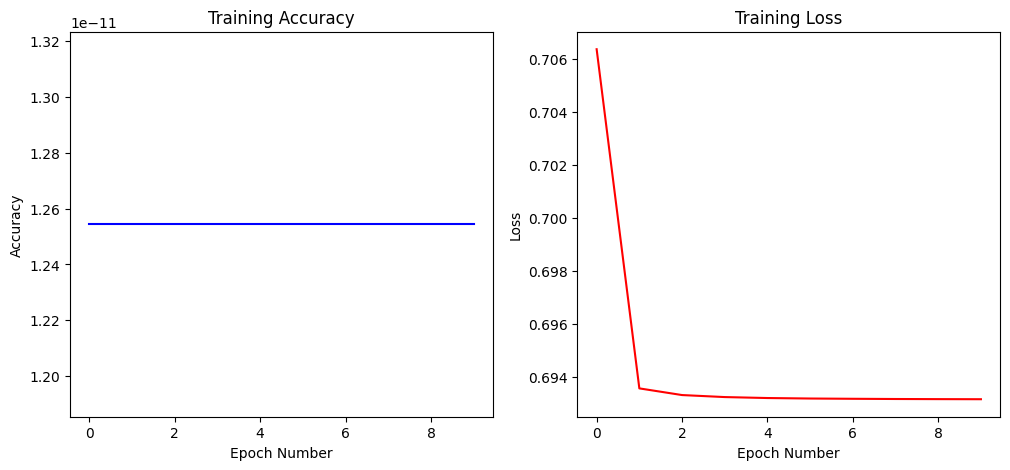

In [ ]:
# Plotting accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch_ious, label='IoU', color='blue')
plt.title("Training Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epoch_losses, label='Loss', color='red')
plt.title("Training Loss")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")

In [11]:
# During inference / testing / deployment, we want to remove data augmentations from the input transform:
inference_preprocessing = transforms.Compose([ ResizeAndPad(target_size, 14),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                             ]
                                            )

In [12]:
def inference_on_validation_data(inference_model, n_test_images=1):

    for class_name in class_names:
        # gather N validation images per class
        val_class_dir = "{}/{}".format(valid_dataset_dir, class_name)
        val_test_images = os.listdir(val_class_dir)[:n_test_images]

        for val_test_image in val_test_images:

            if ".jpg" not in val_test_image and ".png" not in val_test_image:
                continue

            # load image
            img = Image.open("{}/{}".format(val_class_dir, val_test_image))

            # pre-process image and load onto device
            img_tensor = inference_preprocessing(img)
            img_tensor = img_tensor.unsqueeze(0)
            input_tensor = img_tensor.to(device)

            # run model on input image data
            with torch.no_grad():
                embeddings = inference_model.transformer(input_tensor)
                x = inference_model.transformer.norm(embeddings)
                output_tensor = inference_model.classifier(x)

                # sigmoid
                score = output_tensor[0][0].item()
                score = 1 / (1 + np.exp(-score)) 

                # for binary classification, we can just interpret class name based on the 1 output score
                predicted_class = class_names[1] if score > 0.5 else class_names[0]

                print("\n\n\nDinoV2 Predicted = {} vs. Ground Truth = {}:".format(predicted_class, class_name))
                plt.imshow(img) 
                plt.show()

In [ ]:
# save the model
torch.save(model.state_dict(), '{}/classifier.pth'.format(local_directory))

In [ ]:
# reloading the model with trained classification weights to demonstrate deployment
classifier = DinoVisionTransformerClassifier("small")

classifier.load_state_dict(torch.load('{}/classifier.pth'.format(local_directory)))

classifier = classifier.to(device)
classifier.eval()

In [ ]:
# Images from Creative Commons
# https://upload.wikimedia.org/wikipedia/commons/0/03/Lurie_Garden_%28Piet_Oudolf%29_-_Millennium_Park_-_Chicago_IL_%287833308160%29.jpg
# https://upload.wikimedia.org/wikipedia/commons/9/94/Adjoining_Industrial_Buildings_in_10-12-14_Ej%C3%A9rcito_Espa%C3%B1ol_street%2C_Valencia.jpg

inference_on_validation_data(inference_model=classifier, n_test_images=1)